# Clasificación y Optimización de Hiperparámetros: Medical Cost Dataset

## Carga y Exploración Inicial de Datos

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Cargar el dataset
data = pd.read_csv('insurance.csv')

# Explorar estructura
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


## Preprocesamiento de Datos

In [8]:
# Crear variable objetivo binaria (1 si charges > mediana, 0 si no)
data['high_cost'] = (data['charges'] > data['charges'].median()).astype(int)

# Separar variables predictoras y objetivo
X = data.drop(columns=['charges', 'high_cost'])
y = data['high_cost']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento: Escalado y codificación de variables categóricas
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'bmi', 'children']),
                                ('cat', OneHotEncoder(),
                                 ['sex', 'smoker', 'region'])])

## Implementación de Modelos de Clasificación

In [9]:
# Modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Pipeline
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)]) for name, model in models.items()}

# Evaluación inicial con validación cruzada
for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} - Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

Logistic Regression - Accuracy: 0.9047 (+/- 0.0163)
KNN - Accuracy: 0.8794 (+/- 0.0183)
Decision Tree - Accuracy: 0.8897 (+/- 0.0269)


## Optimización de Hiperparámetros

In [10]:
# GridSearchCV para Logistic Regression
param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(pipelines['Logistic Regression'], param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)
print("Mejores hiperparámetros para Logistic Regression:", grid_lr.best_params_)

# RandomizedSearchCV para Decision Tree
param_dist_dt = {
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

random_dt = RandomizedSearchCV(pipelines['Decision Tree'], param_dist_dt, cv=5, scoring='accuracy', n_iter=10, random_state=42)
random_dt.fit(X_train, y_train)
print("Mejores hiperparámetros para Decision Tree:", random_dt.best_params_)

Mejores hiperparámetros para Logistic Regression: {'classifier__C': 1, 'classifier__solver': 'lbfgs'}
Mejores hiperparámetros para Decision Tree: {'classifier__min_samples_split': 5, 'classifier__max_depth': 5}


## Evaluación de Modelos Optimizados


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       146
           1       0.88      0.93      0.90       122

    accuracy                           0.91       268
   macro avg       0.91      0.91      0.91       268
weighted avg       0.91      0.91      0.91       268



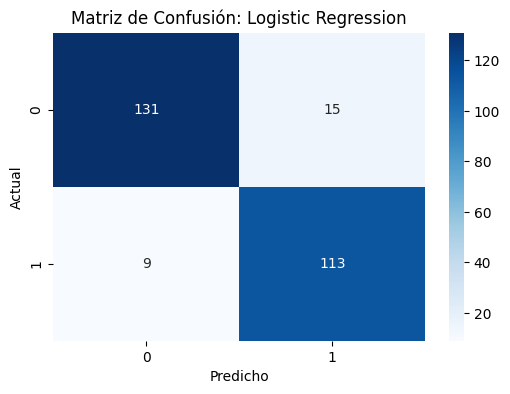

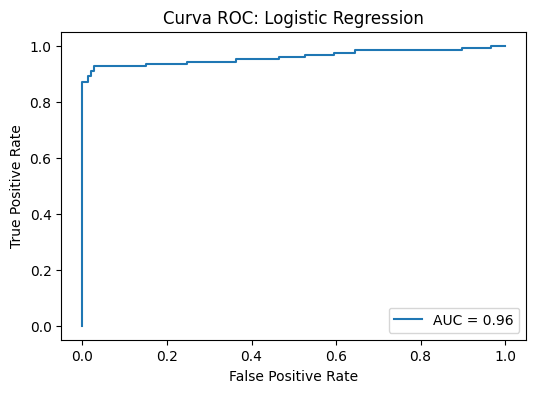


Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.99      0.94       146
           1       0.98      0.88      0.93       122

    accuracy                           0.94       268
   macro avg       0.94      0.93      0.94       268
weighted avg       0.94      0.94      0.94       268



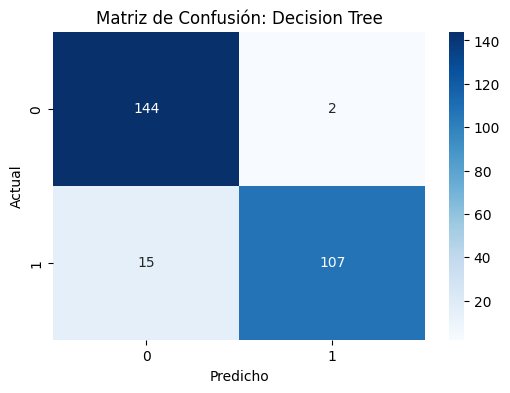

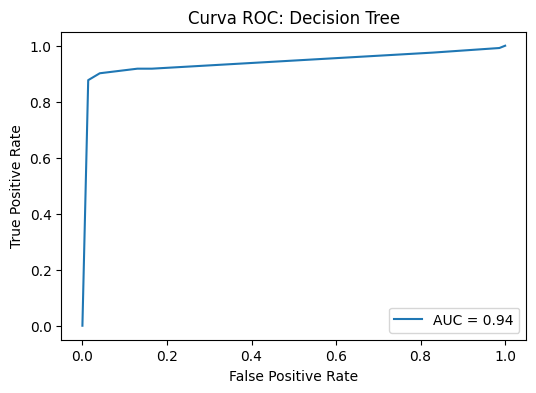

In [11]:
# Evaluación en datos de prueba
final_models = {
    'Logistic Regression': grid_lr.best_estimator_,
    'Decision Tree': random_dt.best_estimator_
}

for name, model in final_models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusión: {name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicho')
    plt.show()

    # Curva ROC
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.title(f"Curva ROC: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()